In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append('../scripts/')
import mapreader
from mapreader import PatchDataset
import cartopy
from torchvision import models
from torch import nn
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import glob
from rasterio.mask import mask
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from shapely.ops import unary_union
from dotenv import load_dotenv
from osdatahub import NGD
import numpy as np
import matplotlib
if tuple([int(x) for x in matplotlib.__version__.split('.')]) < (3, 5, 0):
    print(f'MPL version {matplotlib.__version__} is too old to support plt.axline(), so do not use this function or update to 3.5.0 or higher')
import PIL
from PIL import Image
import cv2
import pandas as pd
import keras_ocr

# Import custom classes **see https://github.com/pdnpa/cnn-boundaries/tree/main/scripts**
from geospatial_masking import Mask, Text_Mask, RasterPlotter, CombinedMask
import historic_wall_inference as hwi

2024-04-05 16:18:04.880439: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 16:18:04.900378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 16:18:04.900398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 16:18:04.901083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 16:18:04.904778: I tensorflow/core/platform/cpu_feature_guar

MapReader Mask

### Load .tif

In [2]:
# load map tif paths
from mapreader import loader
my_files = loader("../content/tifs/masked/*.tif")
my_files.add_geo_info(target_crs='EPSG:27700') # if pre georeferenced may need to set: target_crs 
print(my_files)

  0%|          | 0/500 [00:00<?, ?it/s]

#images: 500

#parents: 500
SK1054_combined.tif
SK1368_combined.tif
SK2068_combined.tif
SK1755_combined.tif
SK2859_combined.tif
SK1472_combined.tif
SK1678_combined.tif
SK0958_combined.tif
SK2557_combined.tif
SK1455_combined.tif
SK1050_combined.tif
...

#patches: 0



### Patchify

In [33]:
# set directory & patch size (pixels unless -- method="meters" )
my_files.patchify_all(path_save="../content/tifs/patches/", patch_size=25)
#my_files.save_patches_as_geotiffs(crs='EPSG:27700')

[INFO] Saving patches in directory named "../content/tifs/patches/".


  0%|          | 0/500 [00:00<?, ?it/s]

../content/tifs/masked/SK1054_combined.tif
../content/tifs/masked/SK1368_combined.tif
../content/tifs/masked/SK2068_combined.tif
../content/tifs/masked/SK1755_combined.tif
../content/tifs/masked/SK2859_combined.tif
../content/tifs/masked/SK1472_combined.tif
../content/tifs/masked/SK1678_combined.tif
../content/tifs/masked/SK0958_combined.tif
../content/tifs/masked/SK2557_combined.tif
../content/tifs/masked/SK1455_combined.tif
../content/tifs/masked/SK1050_combined.tif
../content/tifs/masked/SK1570_combined.tif
../content/tifs/masked/SK2156_combined.tif
../content/tifs/masked/SK1053_combined.tif
../content/tifs/masked/SK0855_combined.tif
../content/tifs/masked/SK2157_combined.tif
../content/tifs/masked/SK1362_combined.tif
../content/tifs/masked/SK1977_combined.tif
../content/tifs/masked/SK1470_combined.tif
../content/tifs/masked/SK0668_combined.tif
../content/tifs/masked/SK1068_combined.tif
../content/tifs/masked/SK0569_combined.tif
../content/tifs/masked/SK2760_combined.tif
../content/

In [2]:
#### or load df if already created ####
patch_df = pd.read_csv('patch_df.csv')
parent_df = pd.read_csv('parent_df.csv')

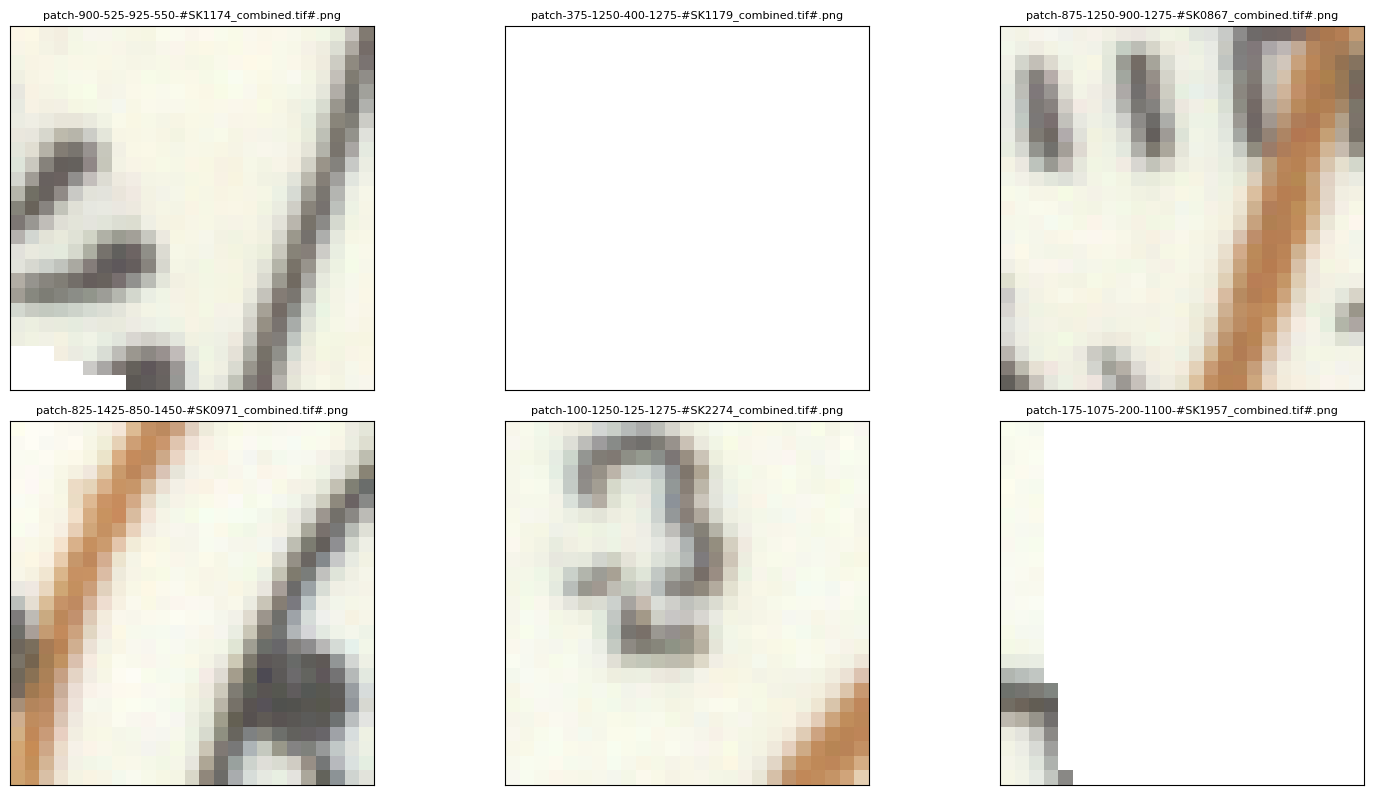

In [46]:
my_files.show_sample(num_samples=6, tree_level="patch")

  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 1 Axes>]

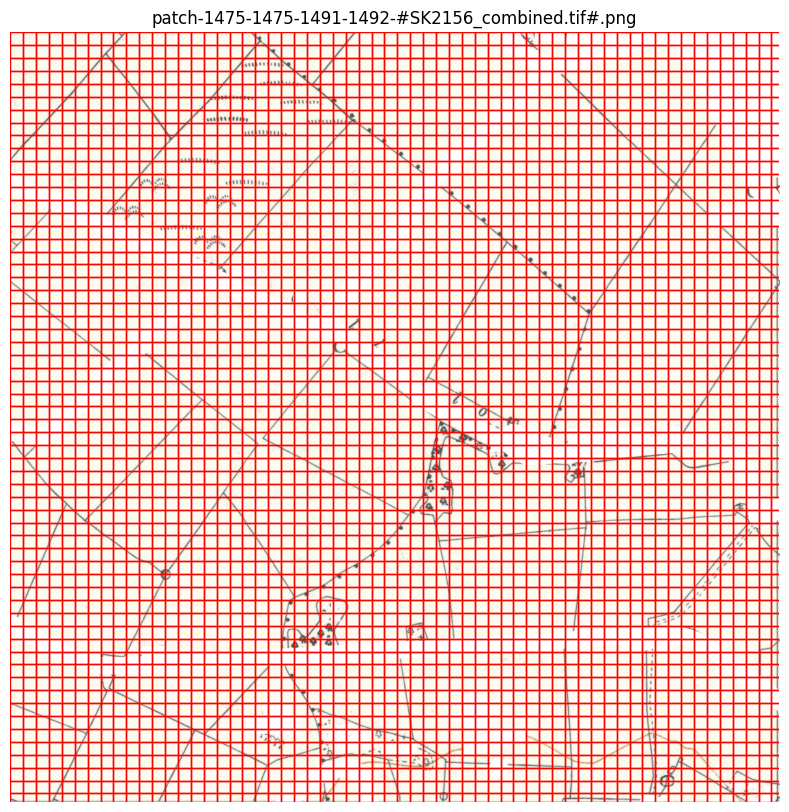

In [29]:
# show patches
parent_list = my_files.list_parents()
my_files.show_parent(parent_list[12])

In [47]:
my_files.calc_pixel_stats()

  0%|          | 0/500 [00:00<?, ?it/s]

In [48]:
parent_df, patch_df = my_files.convert_images(save=True)

[INFO] Saved parent dataframe as "parent_df.csv"
[INFO] Saved patch dataframe as "patch_df.csv"


In [4]:
parent_df.head(2)

image_id  parent_id  \
0  SK1054_combined.tif        NaN   
1  SK1368_combined.tif        NaN   

                                          image_path  \
0  /home/david/Documents/GitHub/cnn-boundaries/co...   
1  /home/david/Documents/GitHub/cnn-boundaries/co...   

                                         coordinates         crs  \
0  (409999.7733136392, 353999.5285585779, 411000....  EPSG:27700   
1  (412999.5264728155, 367999.5729961047, 414000....  EPSG:27700   

             shape                                            patches  \
0  (1492, 1491, 3)  ['patch-0-0-25-25-#SK1054_combined.tif#.png', ...   
1  (1492, 1492, 3)  ['patch-0-0-25-25-#SK1368_combined.tif#.png', ...   

       dlon      dlat  
0  0.670873  0.670873  
1  0.670767  0.670767

In [5]:
patch_df.head(2)

image_id            parent_id  \
0   patch-0-0-25-25-#SK1054_combined.tif#.png  SK1054_combined.tif   
1  patch-0-25-25-50-#SK1054_combined.tif#.png  SK1054_combined.tif   

                                          image_path        shape  \
0  /home/david/Documents/GitHub/cnn-boundaries/co...  (25, 25, 3)   
1  /home/david/Documents/GitHub/cnn-boundaries/co...  (25, 25, 3)   

      pixel_bounds                                        coordinates  \
0   (0, 0, 25, 25)  (409999.7733136392, 354983.69951655285, 410016...   
1  (0, 25, 25, 50)  (409999.7733136392, 354966.92768700316, 410016...   

          crs                                            polygon  \
0  EPSG:27700  POLYGON ((410016.5451431889 354983.69951655285...   
1  EPSG:27700  POLYGON ((410016.5451431889 354966.92768700316...   

   mean_pixel_R  mean_pixel_G  mean_pixel_B  std_pixel_R  std_pixel_G  \
0      1.000000      1.000000       1.00000     0.000000     0.000000   
1      0.979972      0.964009       0.94646     0.059534     0.108736   

   std_pixel_B  
0     0.000000  
1     0.153369

### Annotate

In [3]:
from mapreader import Annotator

annotator = Annotator(
    "./patch_df.csv",
    "./parent_df.csv",
    task_name="walls",
    labels=["no_wall", "wall"],
    annotations_dir = "../content/annotations_1950/",
    username="DavidA",
    show_context=True,
)


[INFO] Loading existing patch annotations.


In [67]:
annotator.annotate(resize_to=300, show_context=True, surrounding=3) #to resize up the tiny patch, you might also want show_context=False as its confusing

Output(layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [4]:
# save annotations
annotator.annotations_file

'../content/annotations_1950/walls_#DavidA#-3390b6646c75bb12e62fd1cf1f851db0.csv'

## Train

### Setup GPU

In [5]:
#### Allow Memeory Growth ####
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth config before initializing GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Initialize the GPUs
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-03-28 11:08:01.798915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 11:08:01.799639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 11:08:01.799755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Read annotations

In [6]:
# Load and check annotations Or read from file
#df = pd.read_csv('../content/annotations_1950/walls_#DavidA#-3390b6646c75bb12e62fd1cf1f851db0.csv', index_col=0) 
df = pd.read_csv(annotator.annotations_file, index_col=0)


df["image_id"]=df.index

from mapreader import AnnotationsLoader
annotated_images = AnnotationsLoader()
annotated_images.load(annotations=df)

[INFO] Number of annotations:   2018

[INFO] Number of instances of each label (from column "label"):
    - no_wall:  1592
    - wall:  426



In [7]:
# view the data
annotated_images.annotations.head(2)

label  \
image_id                                                     
patch-100-1475-125-1491-#SK0468_combined.tif#.png  no_wall   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  no_wall   

                                                                                          image_path  \
image_id                                                                                               
patch-100-1475-125-1491-#SK0468_combined.tif#.png  /home/david/Documents/GitHub/cnn-boundaries/co...   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  /home/david/Documents/GitHub/cnn-boundaries/co...   

                                                             parent_id  \
image_id                                                                 
patch-100-1475-125-1491-#SK0468_combined.tif#.png  SK0468_combined.tif   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  SK0468_combined.tif   

                                                             pixel_bounds  \
image_id                                                                    
patch-100-1475-125-1491-#SK0468_combined.tif#.png  (100, 1475, 125, 1491)   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  (1075, 850, 1100, 875)   

                                                                                            image_id  \
image_id                                                                                               
patch-100-1475-125-1491-#SK0468_combined.tif#.png  patch-100-1475-125-1491-#SK0468_combined.tif#.png   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  patch-1075-850-1100-875-#SK0468_combined.tif#.png   

                                                   label_index  
image_id                                                        
patch-100-1475-125-1491-#SK0468_combined.tif#.png            0  
patch-1075-850-1100-875-#SK0468_combined.tif#.png            0

## Prepare datasets and dataloaders

In [8]:
annotated_images.create_datasets(frac_train=0.7, frac_val=0.2, frac_test=0.1, context_datasets=False, context_df= "./patch_df.csv")

[INFO] Number of annotations in each set:
    - train:   1412
    - val:   404
    - test:   202


In [9]:
annotated_images.labels_map

{0: 'no_wall', 1: 'wall'}

In [10]:
# Prepare datasets and dataloaders
dataloaders = annotated_images.create_dataloaders(batch_size=16)

[INFO] Using default sampler.


## Set up ClassifierContainer

In [11]:
from mapreader import ClassifierContainer
my_classifier = ClassifierContainer("resnet18", annotated_images.labels_map, dataloaders)

[INFO] Device is set to cuda:0
[INFO] Initializing model.
[INFO] Loaded "train" with 1412 items.
[INFO] Loaded "val" with 404 items.
[INFO] Loaded "test" with 202 items.


[INFO] dataset: train
        - items:        1412
        - batch size:   16
        - batches:      89


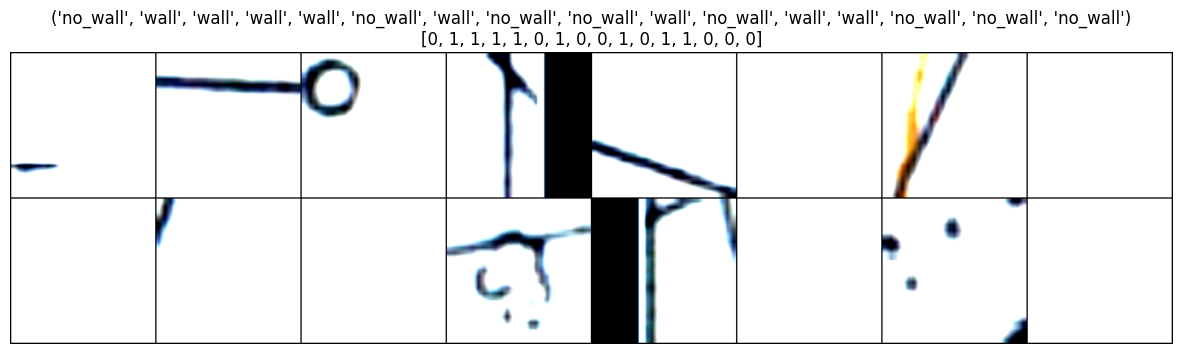

In [12]:
my_classifier.show_sample(set_name="train", batch_number=1)

In [13]:
from torchinfo import summary
import torch


summary(my_classifier, input_size=(1, 3, 224, 224)) 

AttributeError: 'ClassifierContainer' object has no attribute 'parameters'

In [14]:
my_classifier.model_summary()

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #
ResNet                                   [16, 2]                   [16, 2]                   --
├─Conv2d: 1-1                            [16, 64, 112, 112]        [16, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        [16, 64, 112, 112]        128
├─ReLU: 1-3                              [16, 64, 112, 112]        [16, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          [16, 64, 56, 56]          --
├─Sequential: 1-5                        [16, 64, 56, 56]          [16, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [16, 64, 56, 56]          [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [16, 64, 56, 56]          [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 56, 56]          [16, 64, 56, 56]          128
│    │    └─ReLU: 3-3     

### Set up criterion, optimizer and scheduler

In [15]:
# loss function
my_classifier.add_criterion("cross-entropy")

[INFO] Using "CrossEntropyLoss()" as criterion.


In [16]:
params_to_optimize = my_classifier.generate_layerwise_lrs(
    min_lr=1e-4, max_lr=1e-3, spacing="geomspace")

In [17]:
my_classifier.initialize_optimizer(params2optimize=params_to_optimize)

In [18]:
# scheduler
my_classifier.initialize_scheduler()

### Train/fine-tune model

In [19]:
my_classifier.train(
    num_epochs=30,
    save_model_dir="models_train",
    tensorboard_path="tboard_tutorial",
    tmp_file_save_freq=5,
    remove_after_load=False,
    print_info_batch_freq=10,
)

[INFO] Each step will pass: ['train', 'val'].
2024-03-28 11:08:35 david-LEGI [INFO] train    -- 1/30 --    16/1412 (  1.1% ) -- Loss: 1.075
2024-03-28 11:08:35 david-LEGI [INFO] train    -- 1/30 --   176/1412 ( 12.5% ) -- Loss: 1.228
2024-03-28 11:08:36 david-LEGI [INFO] train    -- 1/30 --   336/1412 ( 23.8% ) -- Loss: 0.514
2024-03-28 11:08:36 david-LEGI [INFO] train    -- 1/30 --   496/1412 ( 35.1% ) -- Loss: 0.383
2024-03-28 11:08:36 david-LEGI [INFO] train    -- 1/30 --   656/1412 ( 46.5% ) -- Loss: 0.371
2024-03-28 11:08:37 david-LEGI [INFO] train    -- 1/30 --   816/1412 ( 57.8% ) -- Loss: 0.190
2024-03-28 11:08:37 david-LEGI [INFO] train    -- 1/30 --   976/1412 ( 69.1% ) -- Loss: 0.189
2024-03-28 11:08:38 david-LEGI [INFO] train    -- 1/30 --  1136/1412 ( 80.5% ) -- Loss: 0.122
2024-03-28 11:08:38 david-LEGI [INFO] train    -- 1/30 --  1296/1412 ( 91.8% ) -- Loss: 0.047
2024-03-28 11:08:38 david-LEGI [INFO] train    -- 1/30 -- Loss: 0.357; F_macro: 87.38; R_macro: 87.36
2024-0

### Plot metrics

In [20]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

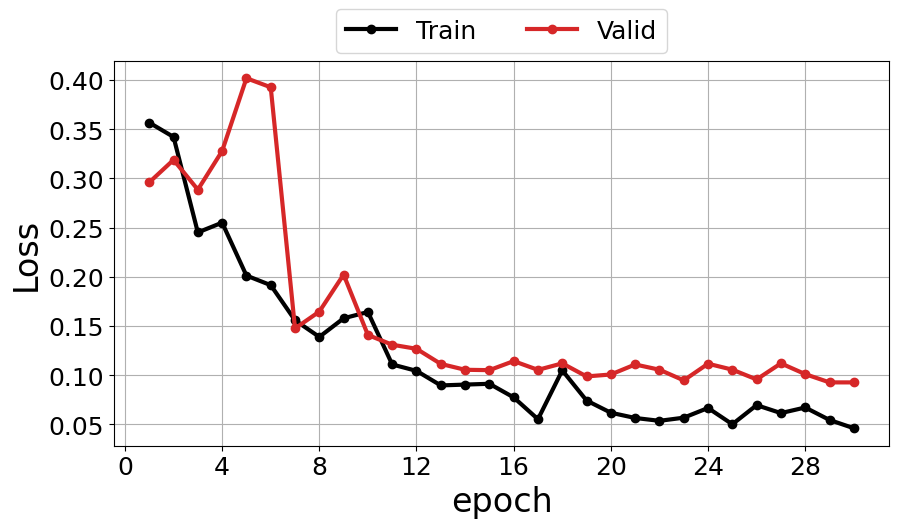

In [21]:
# loss per epoch of training and validation
my_classifier.plot_metric(
    y_axis=["epoch_loss_train", "epoch_loss_val"],
    y_label="Loss",
    legends=["Train", "Valid"],
)

### Model inference

In [22]:
my_classifier.inference(set_name="test")

[INFO] Each step will pass: ['test'].
2024-03-28 12:35:26 david-LEGI [INFO] test     -- 31/31 --     16/202 (  7.9% ) -- 
2024-03-28 12:35:26 david-LEGI [INFO] test     -- 31/31 --     96/202 ( 47.5% ) -- 
2024-03-28 12:35:26 david-LEGI [INFO] test     -- 31/31 --    176/202 ( 87.1% ) -- 
[INFO] Total time: 0m 0s


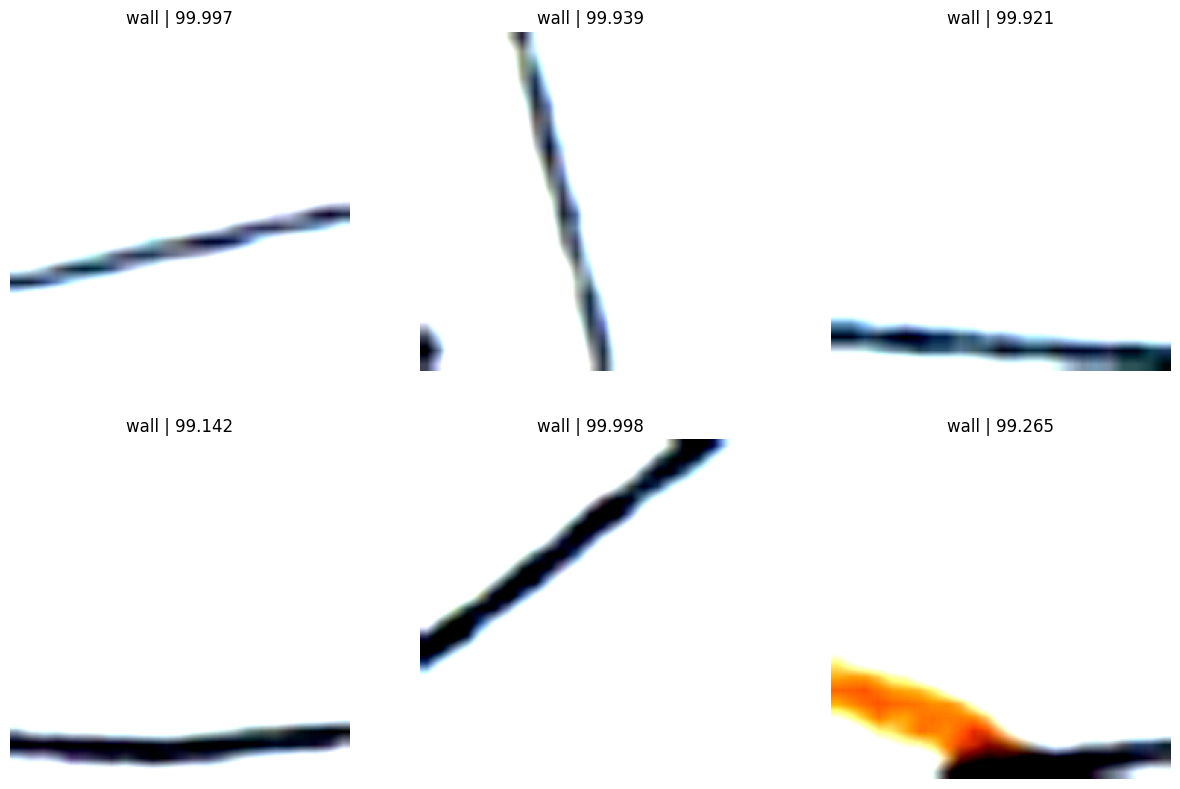

In [23]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall")

### Save

In [24]:
my_classifier.save("../notebooks/models/test_15.pkl")

### Model Inference

In [25]:
infer = PatchDataset("../content/annotations_1950/walls_#DavidA#-3390b6646c75bb12e62fd1cf1f851db0.csv", delimiter=",", transform="test")

[INFO] Reading "../content/annotations_1950/walls_#DavidA#-3390b6646c75bb12e62fd1cf1f851db0.csv".


In [26]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(infer, set_name="infer")

In [27]:
my_classifier.inference(set_name="infer")

[INFO] Each step will pass: ['infer'].
2024-03-28 12:35:45 david-LEGI [INFO] infer    -- 31/31 --    16/2018 (  0.8% ) -- 
2024-03-28 12:35:45 david-LEGI [INFO] infer    -- 31/31 --    96/2018 (  4.8% ) -- 
2024-03-28 12:35:45 david-LEGI [INFO] infer    -- 31/31 --   176/2018 (  8.7% ) -- 
2024-03-28 12:35:45 david-LEGI [INFO] infer    -- 31/31 --   256/2018 ( 12.7% ) -- 
2024-03-28 12:35:45 david-LEGI [INFO] infer    -- 31/31 --   336/2018 ( 16.7% ) -- 
2024-03-28 12:35:45 david-LEGI [INFO] infer    -- 31/31 --   416/2018 ( 20.6% ) -- 
2024-03-28 12:35:45 david-LEGI [INFO] infer    -- 31/31 --   496/2018 ( 24.6% ) -- 
2024-03-28 12:35:46 david-LEGI [INFO] infer    -- 31/31 --   576/2018 ( 28.5% ) -- 
2024-03-28 12:35:46 david-LEGI [INFO] infer    -- 31/31 --   656/2018 ( 32.5% ) -- 
2024-03-28 12:35:46 david-LEGI [INFO] infer    -- 31/31 --   736/2018 ( 36.5% ) -- 
2024-03-28 12:35:46 david-LEGI [INFO] infer    -- 31/31 --   816/2018 ( 40.4% ) -- 
2024-03-28 12:35:46 david-LEGI [INFO]

### Add predictions to metadata and save

In [28]:
infer.patch_df['predicted_label'] = my_classifier.pred_label
infer.patch_df['pred'] = my_classifier.pred_label_indices
infer.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [29]:
infer.patch_df.head(2)

label  \
image_id                                                     
patch-100-1475-125-1491-#SK0468_combined.tif#.png  no_wall   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  no_wall   

                                                                                          image_path  \
image_id                                                                                               
patch-100-1475-125-1491-#SK0468_combined.tif#.png  /home/david/Documents/GitHub/cnn-boundaries/co...   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  /home/david/Documents/GitHub/cnn-boundaries/co...   

                                                             parent_id  \
image_id                                                                 
patch-100-1475-125-1491-#SK0468_combined.tif#.png  SK0468_combined.tif   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  SK0468_combined.tif   

                                                             pixel_bounds  \
image_id                                                                    
patch-100-1475-125-1491-#SK0468_combined.tif#.png  (100, 1475, 125, 1491)   
patch-1075-850-1100-875-#SK0468_combined.tif#.png  (1075, 850, 1100, 875)   

                                                  predicted_label  pred  \
image_id                                                                  
patch-100-1475-125-1491-#SK0468_combined.tif#.png         no_wall     0   
patch-1075-850-1100-875-#SK0468_combined.tif#.png         no_wall     0   

                                                       conf  
image_id                                                     
patch-100-1475-125-1491-#SK0468_combined.tif#.png  0.945807  
patch-1075-850-1100-875-#SK0468_combined.tif#.png  0.606623

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1800000 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

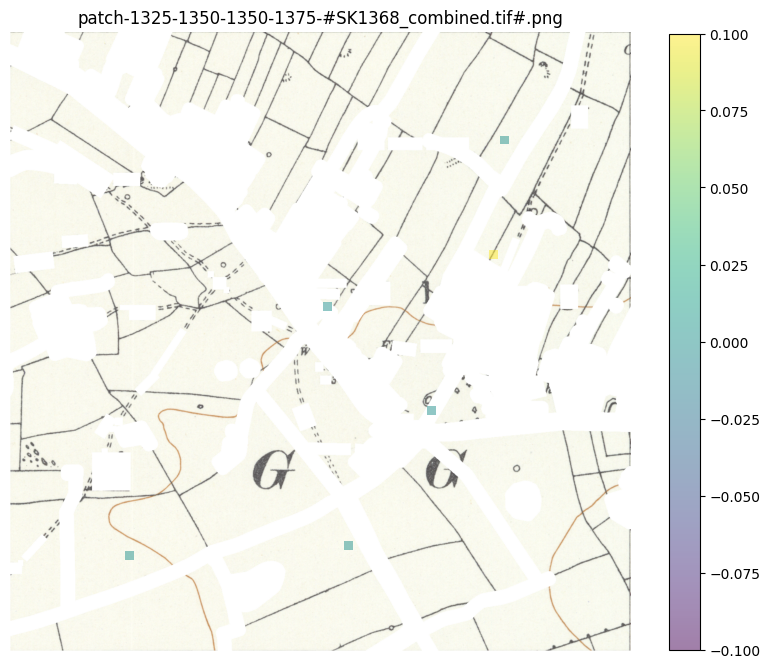

In [36]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

infer_df = infer.patch_df
my_maps.add_metadata(infer_df, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[1], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

### Full data test

In [30]:
patch_df = pd.read_csv("./patch_df.csv")
patch_df.reset_index(inplace=True, drop=False)
predictions = PatchDataset(patch_df, transform="test")
predictions

In [31]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(predictions, set_name="predictions")

In [33]:
my_classifier.inference(set_name="predictions")

[INFO] Each step will pass: ['predictions'].
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 16/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 96/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 176/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 256/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 336/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 416/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 496/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 576/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 656/1800000 (  0.0% ) -- 
2024-03-28 13:03:31 david-LEGI [INFO] predictions -- 31/31 -- 736/1800000 (  0.0% ) -- 
2024-03-28 13:03:32 david-LEGI [INFO] predictions -- 31/31 -- 816/1800000 (  

In [34]:
predictions.patch_df['predicted_label'] = my_classifier.pred_label
predictions.patch_df['pred'] = my_classifier.pred_label_indices
predictions.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [35]:
from mapreader import load_patches
#my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

patch_df_predictions = predictions.patch_df
#my_maps.add_metadata(patch_df_predictions, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
#my_maps.add_shape()

#parent_list = my_maps.list_parents()
#my_maps.show_parent(parent_list[12], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

In [36]:
patch_df_predictions.head(1)

index            parent_id  \
image_id                                                                
patch-0-0-25-25-#SK1054_combined.tif#.png      0  SK1054_combined.tif   

                                                                                  image_path  \
image_id                                                                                       
patch-0-0-25-25-#SK1054_combined.tif#.png  /home/david/Documents/GitHub/cnn-boundaries/co...   

                                                 shape    pixel_bounds  \
image_id                                                                 
patch-0-0-25-25-#SK1054_combined.tif#.png  (25, 25, 3)  (0, 0, 25, 25)   

                                                                                 coordinates  \
image_id                                                                                       
patch-0-0-25-25-#SK1054_combined.tif#.png  (409999.7733136392, 354983.69951655285, 410016...   

                                                  crs  \
image_id                                                
patch-0-0-25-25-#SK1054_combined.tif#.png  EPSG:27700   

                                                                                     polygon  \
image_id                                                                                       
patch-0-0-25-25-#SK1054_combined.tif#.png  POLYGON ((410016.5451431889 354983.69951655285...   

                                           mean_pixel_R  mean_pixel_G  \
image_id                                                                
patch-0-0-25-25-#SK1054_combined.tif#.png           1.0           1.0   

                                           mean_pixel_B  std_pixel_R  \
image_id                                                               
patch-0-0-25-25-#SK1054_combined.tif#.png           1.0          0.0   

                                           std_pixel_G  std_pixel_B  \
image_id                                                              
patch-0-0-25-25-#SK1054_combined.tif#.png          0.0          0.0   

                                          predicted_label  pred      conf  
image_id                                                                   
patch-0-0-25-25-#SK1054_combined.tif#.png         no_wall     0  0.999704

In [ ]:
### Does not work ###

# Export the file in GIS to set to ESPG: 27700
# change tuple columns to strings
for col in patch_df_predictions.columns:
    if isinstance(patch_df_predictions[col][0], tuple):
        patch_df_predictions[col] = patch_df_predictions[col].apply(str)

geo_patch_df = gpd.GeoDataFrame(patch_df_predictions, geometry="coordinates", crs='EPSG:27700')
geo_patch_df.to_file("../content/predictions/patches.geojson", driver="GeoJSON")

In [43]:
from shapely import wkt
import geopandas as gpd

# Convert the WKT polygon strings to Shapely geometry objects
patch_df_predictions['geometry'] = patch_df_predictions['polygon'].apply(wkt.loads)

# Create a GeoDataFrame using the 'geometry' column for geometries, ensuring the CRS is set to EPSG:27700
geo_patch_df = gpd.GeoDataFrame(patch_df_predictions.drop(columns=['polygon']), geometry='geometry', crs='EPSG:27700')

# Save the GeoDataFrame to a GeoJSON file
geo_patch_df.to_file("../content/predictions/patches.geojson", driver="GeoJSON")

In [44]:
patch_df.shape[0]

1800000

### Use the mapreader exported file to create a mask

In [47]:
def apply_mask_to_rasters(shapefile_path, raster_folder, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Load and prepare the shapefile
    gdf = gpd.read_file(shapefile_path)
    gdf['pred'] = gdf['pred'].astype(int)
    
    # Iterate over raster files
    for raster_filename in os.listdir(raster_folder):
        if raster_filename.endswith(".tif"):
            print(f"Processing {raster_filename}...")
            raster_path = os.path.join(raster_folder, raster_filename)
            output_raster_path = os.path.join(output_folder, raster_filename.replace("_combined_tif", "_mapreader_mask.tif"))
            
            # Open the raster
            with rasterio.open(raster_path) as src:
                out_meta = src.meta.copy()
                
                # Ensure gdf is in the same CRS as the raster
                gdf_in_raster_crs = gdf.to_crs(src.crs)
                
                # Select geometries where pred == 0
                mask_geometries = gdf_in_raster_crs[gdf_in_raster_crs['pred'] == 0]['geometry']
                
                if not mask_geometries.empty:
                    # Generate mask for the selected geometries
                    out_image, _ = mask(src, mask_geometries, invert=True, filled=True, nodata=0)
                    
                    # Set masked areas to white (255)
                    out_image[out_image == 0] = 255
                else:
                    # Read the entire array if no masking needed
                    out_image = src.read()

                # Save the modified raster
                with rasterio.open(output_raster_path, "w", **out_meta) as dest:
                    dest.write(out_image)
            print(f"Finished {raster_filename}.")

In [48]:
# Call the function with your paths
apply_mask_to_rasters("../content/predictions/patches_ESPG_27700.shp", "../content/tifs/masked/", "../content/tifs/mapreader_masks/")

Processing SK1054_combined.tif...
Finished SK1054_combined.tif.
Processing SK1368_combined.tif...
Finished SK1368_combined.tif.
Processing SK2068_combined.tif...
Finished SK2068_combined.tif.
Processing SK1755_combined.tif...
Finished SK1755_combined.tif.
Processing SK2859_combined.tif...
Finished SK2859_combined.tif.
Processing SK1472_combined.tif...
Finished SK1472_combined.tif.
Processing SK1678_combined.tif...
Finished SK1678_combined.tif.
Processing SK0958_combined.tif...
Finished SK0958_combined.tif.
Processing SK2557_combined.tif...
Finished SK2557_combined.tif.
Processing SK1455_combined.tif...
Finished SK1455_combined.tif.
Processing SK1050_combined.tif...
Finished SK1050_combined.tif.
Processing SK1570_combined.tif...
Finished SK1570_combined.tif.
Processing SK2156_combined.tif...
Finished SK2156_combined.tif.
Processing SK1053_combined.tif...
Finished SK1053_combined.tif.
Processing SK0855_combined.tif...


KeyboardInterrupt: 

In [52]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box

def apply_mask_to_rasters(shapefile_path, raster_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    gdf = gpd.read_file(shapefile_path)
    gdf['pred'] = gdf['pred'].astype(int)
    gdf_sindex = gdf.sindex  # Create spatial index

    for raster_filename in os.listdir(raster_folder):
        if raster_filename.endswith(".tif"):
            print(f"Processing {raster_filename}...")
            raster_path = os.path.join(raster_folder, raster_filename)
            output_raster_path = os.path.join(output_folder, raster_filename.replace("_combined.tif", "_mapreader_mask.tif"))

            with rasterio.open(raster_path) as src:
                bounds = src.bounds
                bbox_polygon = box(*bounds)  # Convert BoundingBox to a Polygon
                possible_matches_index = list(gdf_sindex.intersection(bbox_polygon.bounds))
                possible_matches = gdf.iloc[possible_matches_index]
                precise_matches = possible_matches[possible_matches.geometry.intersects(bbox_polygon)]

                if not precise_matches.empty:
                    mask_geometries = precise_matches[precise_matches['pred'] == 0]['geometry']
                    out_image, _ = mask(src, mask_geometries, invert=True, filled=True, nodata=0)
                    out_image[out_image == 0] = 255
                else:
                    out_image = src.read()

                with rasterio.open(output_raster_path, "w", **src.meta) as dest:
                    dest.write(out_image)

            print(f"Finished {raster_filename}.")

In [53]:
apply_mask_to_rasters("../content/predictions/patches_ESPG_27700.shp", "../content/tifs/masked/", "../content/tifs/mapreader_masks/")

Processing SK1054_combined.tif...
Finished SK1054_combined.tif.
Processing SK1368_combined.tif...
Finished SK1368_combined.tif.
Processing SK2068_combined.tif...
Finished SK2068_combined.tif.
Processing SK1755_combined.tif...
Finished SK1755_combined.tif.
Processing SK2859_combined.tif...
Finished SK2859_combined.tif.
Processing SK1472_combined.tif...
Finished SK1472_combined.tif.
Processing SK1678_combined.tif...
Finished SK1678_combined.tif.
Processing SK0958_combined.tif...
Finished SK0958_combined.tif.
Processing SK2557_combined.tif...
Finished SK2557_combined.tif.
Processing SK1455_combined.tif...
Finished SK1455_combined.tif.
Processing SK1050_combined.tif...
Finished SK1050_combined.tif.
Processing SK1570_combined.tif...
Finished SK1570_combined.tif.
Processing SK2156_combined.tif...
Finished SK2156_combined.tif.
Processing SK1053_combined.tif...
Finished SK1053_combined.tif.
Processing SK0855_combined.tif...
Finished SK0855_combined.tif.
Processing SK2157_combined.tif...
Finish

##  Contour line mask

### Create contour line masks using cv2

In [3]:
input_folder = "../content/tifs/mapreader_masks/"
output_folder_line_masks = "../content/tifs/line_masks/"

# Ensure the output directory exists
os.makedirs(output_folder_line_masks, exist_ok=True)

# Loop through all images in the input folder and apply the line mask
for filename in os.listdir(input_folder):
    if filename.endswith("_mask.tif"):  # Adjust based on your file naming convention
        input_image_path = os.path.join(input_folder, filename)
        print(f"Applying line mask to {filename}...")
        hwi.apply_line_mask(input_image_path, output_folder_line_masks)  # Pass the folder directly
        print(f"Saved masked image to {output_folder_line_masks}")

Applying line mask to SK1673_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK1763_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK1266_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK1377_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK1681_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK2859_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK1070_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK1269_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK2064_mapreader_mask.tif...
Saved masked image to ../content/tifs/line_masks/
Applying line mask to SK1349_mapreader_mask.tif...
Saved masked image to ../content/tifs/li

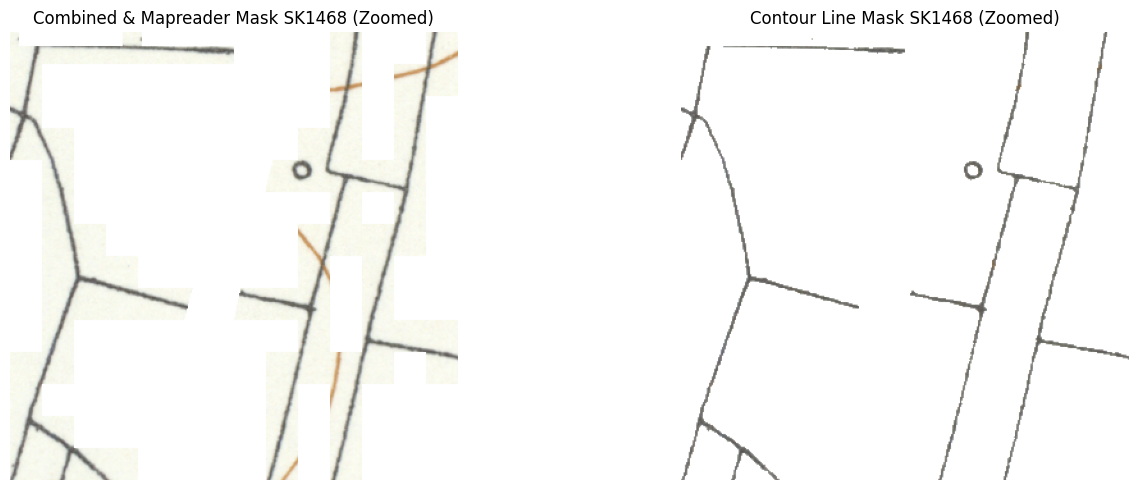

In [7]:
# example image
contour_image_path = "../content/tifs/line_masks/SK1468_mapreader_mask.tif"
combined_mask_path = "../content/tifs/mapreader_masks/SK1468_mapreader_mask.tif"

# Read the images
contour_image = Image.open(contour_image_path)
combined_mask = Image.open(combined_mask_path)

# Define the area to zoom into (x_start, x_end, y_start, y_end)
# Adjust these values as needed to zoom into the top left corner
x_start, x_end = 50, 400  # for example, to select pixels along x-axis
y_start, y_end = 50, 400  # for example, to select pixels along y-axis

# Convert images to numpy arrays for slicing
contour_image_array = np.array(contour_image)
combined_mask_array = np.array(combined_mask)

# Zoom into the top left corner by slicing the array
zoomed_contour_image = contour_image_array[y_start:y_end, x_start:x_end]
zoomed_combined_mask = combined_mask_array[y_start:y_end, x_start:x_end]

# Plot the zoomed images
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(zoomed_combined_mask)
plt.title("Combined & Mapreader Mask SK1468 (Zoomed)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(zoomed_contour_image)
plt.title("Contour Line Mask SK1468 (Zoomed)")
plt.axis('off')

plt.tight_layout()
plt.show()

## 4) Probablistic Hough Transform

In [8]:
output_folder = "../content/predictions/hough-lines/"
line_masks = "../content/tifs/line_masks/"

for filename in os.listdir(line_masks):
    if filename.endswith("_mask.tif"):
        line_masked_image_path = os.path.join(line_masks, filename)
        print(f"Performing Hough Transform on {filename}...") 
        lines = hwi.apply_hough_transform(line_masked_image_path, output_folder)

Performing Hough Transform on SK1673_mapreader_mask.tif...
Performing Hough Transform on SK1763_mapreader_mask.tif...
Performing Hough Transform on SK1266_mapreader_mask.tif...
Performing Hough Transform on SK1377_mapreader_mask.tif...
Performing Hough Transform on SK1681_mapreader_mask.tif...
Performing Hough Transform on SK2859_mapreader_mask.tif...
Performing Hough Transform on SK1070_mapreader_mask.tif...
Performing Hough Transform on SK1269_mapreader_mask.tif...
Performing Hough Transform on SK2064_mapreader_mask.tif...
Performing Hough Transform on SK1349_mapreader_mask.tif...
Performing Hough Transform on SK0769_mapreader_mask.tif...
Performing Hough Transform on SK1656_mapreader_mask.tif...
Performing Hough Transform on SK2173_mapreader_mask.tif...
Performing Hough Transform on SK1164_mapreader_mask.tif...
Performing Hough Transform on SK1451_mapreader_mask.tif...
Performing Hough Transform on SK1252_mapreader_mask.tif...
Performing Hough Transform on SK1570_mapreader_mask.tif.

## 5) Create '1950's wall corridors'

In [9]:
import glob
from shapely.ops import unary_union
# Use glob.glob to recursively search for shapefiles in subfolders
shapefiles_folder = "../content/predictions/hough-lines/"
shapefiles_pattern = os.path.join(shapefiles_folder, "**/*_mask.shp")
shapefiles = glob.glob(shapefiles_pattern, recursive=True)

# Read all shapefiles into GeoDataFrames and concatenate them into one GeoDataFrame
gdfs = [gpd.read_file(shp) for shp in shapefiles]
all_shapes_gdf = pd.concat(gdfs, ignore_index=True)

# Add a buffer of 5 meters to the files (adjust buffer distance if necessary)
buffered_shapes = all_shapes_gdf.geometry.buffer(5)

# Merge This will create a MultiPolygon if shapes are disjoint, or a single Polygon if they all connect.
merged_shape = unary_union(buffered_shapes)

# Create a new GeoDataFrame with the merged shape
final_gdf = gpd.GeoDataFrame(geometry=[merged_shape], crs=all_shapes_gdf.crs)

# Save the file "../content/1950-corridors"
output_path = "../content/1950-corridors/1950-corridors.shp"
final_gdf.to_file(output_path)

### Accuracy

In [11]:
# Combine Mask Shapefiles
mask_files = glob.glob('../QGIS/masks/*.shp')

# Read and combine all shapefiles into one GeoDataFrame
combined_mask = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp) for shp in mask_files], ignore_index=True))

# Save the combined mask shapefile
combined_mask.to_file('../QGIS/masks/combined-mask.shp')

In [69]:
# clip the data to the masks

# Load the masks and data 
mask_gdf = gpd.read_file("../QGIS/masks/combined-mask.shp")
historic_gdf = gpd.read_file("../content/1950-corridors/1950-corridors.shp")
annotations_gdf = gpd.read_file("../content/labels/Walls.shp")

# This subtracts the mask from the historic and annotations datasets
diff_historic = gpd.overlay(historic_gdf, mask_gdf, how='difference')
diff_annotations = gpd.overlay(annotations_gdf, mask_gdf, how='difference')

# Optionally, save the clipped datasets for further analysis
# This subtracts the mask from the historic and annotations datasets
diff_historic.to_file("../content/1950-corridors/diff_1950_corridors.shp")
diff_annotations.to_file("../content/1950-corridors/diff_annotations_2023.shp")

### Proximity to Annotations

In [61]:
# buffer
gdf_2023_buffered = diff_annotations.buffer(13)
# calc intersection
intersection = diff_historic.intersection(gdf_2023_buffered.unary_union)
# Subtract This Intersection from buffer-1950
difference = diff_historic.geometry - intersection.unary_union
# Any Area Remaining is F+
false_positives_area = difference.area.sum()  # This gives the total area of false positives
# save diff
difference.to_file("../content/1950-corridors/difference.shp")

In [62]:
total_area_1950 = diff_historic.area.sum()
percent_false_positives = (false_positives_area / total_area_1950) * 100
print(f"Percentage of False Positives: {percent_false_positives}%")

Percentage of False Positives: 11.646292024670126%


In [41]:
# Ensure diff_annotations is a GeoDataFrame
if not isinstance(diff_annotations, gpd.GeoDataFrame):
    diff_annotations = gpd.GeoDataFrame(diff_annotations)

# Ensure diff_historic is a GeoDataFrame
if not isinstance(diff_historic, gpd.GeoDataFrame):
    diff_historic = gpd.GeoDataFrame(diff_historic)

In [20]:
# True+ TP
tp_intersection = gpd.overlay(diff_annotations, diff_historic, how='intersection')
true_positives_area = tp_intersection.area.sum()
print(f"Total Area of True Positives: {true_positives_area}")

Total Area of True Positives: 0.0


In [46]:
# True- TN
aoi_area = aoi.area.sum() if isinstance(aoi, gpd.GeoDataFrame) else aoi.area

# Subtract the union of predictions and annotations from the AOI to approximate TN
covered_area = diff_historic.unary_union.union(diff_annotations_buffered.unary_union).area
true_negatives_area = aoi_area - covered_area
print(f"Approximate Area of True Negatives: {true_negatives_area}")

NameError: name 'aoi' is not defined

In [21]:
tp_intersection = diff_annotations.intersection(diff_historic.unary_union)
true_positives_area = tp_intersection.area.sum()
print(f"Total Area of True Positives: {true_positives_area}")

Total Area of True Positives: 0.0


### Comparing the Datasets


## 6) Compare with 2024 Ordnance Survey data

In [3]:
from PIL import Image
import glob
import os

# List of folders to search for TIFF files
folders = [
    "../content/tifs/mapreader_masks/",
    "../content/tifs/line_masks/",
    "../content/tifs/masked/",
    "../content/tifs/1k_tifs/"
]

# Output directory
output_dir = "/home/david/Documents/Design/storymap"
os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

# Search pattern
search_term = "SK1468"

for folder in folders:
    # Construct a search pattern to find relevant TIFF files
    search_pattern = os.path.join(folder, f"*{search_term}*.tif")
    
    # Use glob to find all files matching the pattern
    for tif_file in glob.glob(search_pattern):
        # Construct the PNG filename based on the TIFF filename and the folder
        folder_name = os.path.basename(os.path.normpath(folder))  # Get the name of the folder
        base_name = os.path.basename(tif_file)
        png_filename = f"{folder_name}_{base_name.replace('.tif', '.png')}"  # Prepend folder name to filename
        output_path = os.path.join(output_dir, png_filename)
        
        # Open the TIFF file and convert it to PNG
        with Image.open(tif_file) as img:
            img.save(output_path, "PNG")
        
        print(f"Exported {tif_file} to {output_path}")

print("Conversion completed.")

Exported ../content/tifs/mapreader_masks/SK1468_mapreader_mask.tif to /home/david/Documents/Design/storymap/mapreader_masks_SK1468_mapreader_mask.png
Exported ../content/tifs/line_masks/SK1468_mapreader_mask.tif to /home/david/Documents/Design/storymap/line_masks_SK1468_mapreader_mask.png
Exported ../content/tifs/masked/SK1468_combined.tif to /home/david/Documents/Design/storymap/masked_SK1468_combined.png
Exported ../content/tifs/1k_tifs/SK1468.tif to /home/david/Documents/Design/storymap/1k_tifs_SK1468.png
Conversion completed.
